In [129]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns
import imp
import matrixes
imp.reload(FImatrixesRE)

# Reservoir model

Задача - построить 2D модель резервуара. Для начала необходимо задать свойства полости, такие как $\phi,\ S_{water}, S_{oil} = 1 - S_{water}, c_r, c$. Также величины, фигурирующие в законе Дарси: $k, \mu, \rho$. Будем считать модель изотропной и варьировать лишь $S_{oil}$

## Построение формы резервуара
Будем задавать значения каким -нибудь рандомным способом, но красивым. В `sklearn` есть множество методов создания выборок для классификации, мне понравился этот. Так мы и будем определять где вода, а где нефть.

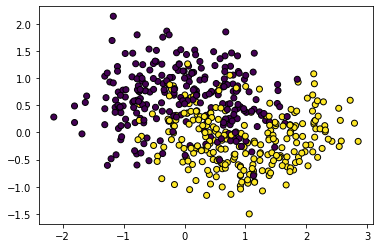

In [130]:
ds = matrixes.get_res_scattered()
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()          

Перенесём всё это на меньший сетку фиксированного размера c фиксированным шагом по следующим правилам
<ol>
<li>Если в ячейке не оказывается ни одного элемента - значит это не пористая структура.

<li>Если оказывается несколько - берёс среднее арифметическое
</ol>

In [132]:
Satur_matrix = get_grid_from_scattered(ds=ds)

NameError: name 'get_grid_from_scattered' is not defined

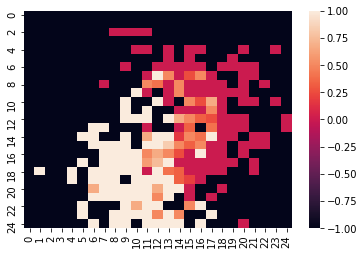

In [128]:
sns.heatmap(Satur_matrix)
plt.show()